# 04 – Model Validation & Threshold Optimization (Credit Card Default Risk)

**Proyecto:** Credit Risk Scoring – UCI Taiwan Dataset  
**Fase DVP-PRO:** F7 – Evaluación y Validación  
**Autor:** Ing. Daniel Varela Pérez  
**Email:** bedaniele0@gmail.com  
**Tel:** +52 55 4189 3428  
**Fecha:** 2025-11-18  
**Versión:** 1.0

---

## Objetivo
Validar formalmente el modelo de riesgo crediticio mediante:
- **Optimización de Threshold:** Encontrar el punto de corte óptimo según costos de negocio
- **Análisis de Fairness:** Evaluar sesgo por género y edad
- **Explicabilidad (XAI):** SHAP values para interpretación
- **Tests de Estabilidad:** Validación estadística y robustez

## Problema Identificado en F5
- **Recall (Default) = 0.3715** (meta: ≥0.70) - NO CUMPLE
- El modelo usa threshold=0.5 por defecto
- Requiere optimización de threshold según costos de negocio

---

## 1. Setup y Carga del Modelo

In [1]:
import sys
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

# Scikit-learn
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report,
    brier_score_loss, f1_score, precision_score, recall_score,
    accuracy_score
)
from sklearn.calibration import calibration_curve

# SHAP para explicabilidad
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP no instalado. Ejecutar: pip install shap")

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Paths
BASE = Path("..").resolve()
DATA = BASE / "data/processed"
MODELS = BASE / "models"
REPORTS = BASE / "reports"

(REPORTS / "figures").mkdir(exist_ok=True)
(REPORTS / "metrics").mkdir(exist_ok=True)

print(f"BASE: {BASE}")
print(f"Python: {sys.version}")

BASE: /Users/danielevarella/Desktop/credit-risk-scoring
Python: 3.13.7 (main, Aug 14 2025, 11:12:11) [Clang 17.0.0 (clang-1700.0.13.3)]


In [2]:
# Cargar modelo y datos
model = joblib.load(MODELS / "final_model.joblib")
print(f"✓ Modelo cargado: {type(model).__name__}")

# Cargar datos
X_train = pd.read_csv(DATA / "X_train.csv")
X_test = pd.read_csv(DATA / "X_test.csv")
y_train = pd.read_csv(DATA / "y_train.csv")["target"]
y_test = pd.read_csv(DATA / "y_test.csv")["target"]

print(f"\nX_test shape: {X_test.shape}")
print(f"y_test distribution:\n{y_test.value_counts()}")

# Probabilidades predichas
y_prob = model.predict_proba(X_test)[:, 1]
print(f"\n✓ Probabilidades predichas generadas")

✓ Modelo cargado: CalibratedClassifierCV

X_test shape: (6000, 36)
y_test distribution:
target
0    4673
1    1327
Name: count, dtype: int64

✓ Probabilidades predichas generadas


In [3]:
# Función de evaluación
def calculate_ks_statistic(y_true, y_prob):
    """Calcula el estadístico KS."""
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    df['cumsum_good'] = (1 - df['y_true']).cumsum() / (1 - df['y_true']).sum()
    df['cumsum_bad'] = df['y_true'].cumsum() / df['y_true'].sum()
    df['ks'] = abs(df['cumsum_bad'] - df['cumsum_good'])
    return df['ks'].max()

def evaluate_at_threshold(y_true, y_prob, threshold=0.5):
    """Evalúa métricas a un threshold específico."""
    y_pred = (y_prob >= threshold).astype(int)
    
    metrics = {
        'threshold': threshold,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc_roc': roc_auc_score(y_true, y_prob),
        'ks': calculate_ks_statistic(y_true, y_prob),
        'brier': brier_score_loss(y_true, y_prob)
    }
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['tp'] = tp
    metrics['tn'] = tn
    metrics['fp'] = fp
    metrics['fn'] = fn
    
    return metrics

print("✓ Funciones de evaluación cargadas")

✓ Funciones de evaluación cargadas


## 2. Análisis de Threshold Actual (0.5)

In [4]:
# Evaluación con threshold por defecto
metrics_default = evaluate_at_threshold(y_test, y_prob, threshold=0.5)

print("="*60)
print("  MÉTRICAS CON THRESHOLD = 0.5 (Por defecto)")
print("="*60)
print(f"  AUC-ROC:    {metrics_default['auc_roc']:.4f}  {'✓' if metrics_default['auc_roc'] >= 0.80 else '✗ (meta: ≥0.80)'}")
print(f"  KS:         {metrics_default['ks']:.4f}  {'✓' if metrics_default['ks'] >= 0.30 else '✗ (meta: ≥0.30)'}")
print(f"  Recall:     {metrics_default['recall']:.4f}  {'✓' if metrics_default['recall'] >= 0.70 else '✗ (meta: ≥0.70)'}")
print(f"  Precision:  {metrics_default['precision']:.4f}  {'✓' if metrics_default['precision'] >= 0.30 else '✗ (meta: ≥0.30)'}")
print(f"  Brier:      {metrics_default['brier']:.4f}  {'✓' if metrics_default['brier'] <= 0.20 else '✗ (meta: ≤0.20)'}")
print(f"  F1-Score:   {metrics_default['f1']:.4f}")
print(f"  Accuracy:   {metrics_default['accuracy']:.4f}")
print("="*60)
print(f"\nConfusion Matrix:")
print(f"  TP (Defaults detectados):     {metrics_default['tp']}")
print(f"  FN (Defaults perdidos):       {metrics_default['fn']} ← PROBLEMA")
print(f"  FP (Falsos positivos):        {metrics_default['fp']}")
print(f"  TN (No-defaults correctos):   {metrics_default['tn']}")

  MÉTRICAS CON THRESHOLD = 0.5 (Por defecto)
  AUC-ROC:    0.7813  ✗ (meta: ≥0.80)
  KS:         0.4251  ✓
  Recall:     0.3715  ✗ (meta: ≥0.70)
  Precision:  0.6591  ✓
  Brier:      0.1349  ✓
  F1-Score:   0.4752
  Accuracy:   0.8185

Confusion Matrix:
  TP (Defaults detectados):     493
  FN (Defaults perdidos):       834 ← PROBLEMA
  FP (Falsos positivos):        255
  TN (No-defaults correctos):   4418


## 3. Optimización de Threshold

### 3.1 Definición de Costos de Negocio

En riesgo crediticio, los costos típicos son:
- **Falso Negativo (FN)**: No detectar un default → Pérdida del crédito completo
- **Falso Positivo (FP)**: Rechazar un cliente bueno → Pérdida de ingresos potenciales

Típicamente: **Costo_FN >> Costo_FP** (perder dinero es peor que perder un cliente)

In [5]:
# Definir costos de negocio
# Ejemplo: Si el crédito promedio es $10,000 y el margen de ganancia es $500
COST_FN = 10000  # Costo de no detectar un default (pérdida del crédito)
COST_FP = 500    # Costo de rechazar un cliente bueno (pérdida de margen)
COST_TP = 0      # Beneficio de detectar correctamente un default
COST_TN = 0      # Beneficio de aprobar correctamente un buen cliente

print("="*60)
print("  MATRIZ DE COSTOS DE NEGOCIO")
print("="*60)
print(f"  Costo Falso Negativo (FN): ${COST_FN:,}")
print(f"  Costo Falso Positivo (FP): ${COST_FP:,}")
print(f"  Ratio FN/FP: {COST_FN/COST_FP:.1f}x")
print("="*60)
print("\n→ Un FN cuesta", int(COST_FN/COST_FP), "veces más que un FP")
print("→ El modelo debe priorizar RECALL sobre PRECISION")

  MATRIZ DE COSTOS DE NEGOCIO
  Costo Falso Negativo (FN): $10,000
  Costo Falso Positivo (FP): $500
  Ratio FN/FP: 20.0x

→ Un FN cuesta 20 veces más que un FP
→ El modelo debe priorizar RECALL sobre PRECISION


In [6]:
# Evaluar múltiples thresholds
thresholds = np.arange(0.05, 0.95, 0.01)
results = []

for thresh in thresholds:
    metrics = evaluate_at_threshold(y_test, y_prob, thresh)
    
    # Calcular costo total
    total_cost = (metrics['fn'] * COST_FN) + (metrics['fp'] * COST_FP)
    metrics['total_cost'] = total_cost
    
    results.append(metrics)

df_thresholds = pd.DataFrame(results)
print(f"✓ Evaluados {len(thresholds)} thresholds")
print(f"\nRango de costos: ${df_thresholds['total_cost'].min():,.0f} - ${df_thresholds['total_cost'].max():,.0f}")

✓ Evaluados 90 thresholds

Rango de costos: $2,325,000 - $13,220,000


In [7]:
# Encontrar thresholds óptimos

# 1. Threshold que minimiza costo total
idx_min_cost = df_thresholds['total_cost'].idxmin()
thresh_min_cost = df_thresholds.loc[idx_min_cost, 'threshold']

# 2. Threshold que maximiza F1-Score
idx_max_f1 = df_thresholds['f1'].idxmax()
thresh_max_f1 = df_thresholds.loc[idx_max_f1, 'threshold']

# 3. Threshold que alcanza Recall >= 0.70 con mejor Precision
df_recall_ok = df_thresholds[df_thresholds['recall'] >= 0.70]
if len(df_recall_ok) > 0:
    idx_best_precision = df_recall_ok['precision'].idxmax()
    thresh_recall_target = df_recall_ok.loc[idx_best_precision, 'threshold']
else:
    thresh_recall_target = df_thresholds.loc[df_thresholds['recall'].idxmax(), 'threshold']

# 4. Threshold de Youden (maximiza Sensitivity + Specificity - 1)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
youden_idx = np.argmax(tpr - fpr)
thresh_youden = roc_thresholds[youden_idx]

print("="*60)
print("  THRESHOLDS ÓPTIMOS IDENTIFICADOS")
print("="*60)
print(f"  1. Minimiza Costo Total:    {thresh_min_cost:.2f}")
print(f"  2. Maximiza F1-Score:       {thresh_max_f1:.2f}")
print(f"  3. Alcanza Recall ≥ 0.70:   {thresh_recall_target:.2f}")
print(f"  4. Youden Index (ROC):      {thresh_youden:.2f}")
print("="*60)

  THRESHOLDS ÓPTIMOS IDENTIFICADOS
  1. Minimiza Costo Total:    0.05
  2. Maximiza F1-Score:       0.27
  3. Alcanza Recall ≥ 0.70:   0.18
  4. Youden Index (ROC):      0.20



✓ Gráfico guardado en: /Users/danielevarella/Desktop/credit-risk-scoring/reports/figures/threshold_optimization.png


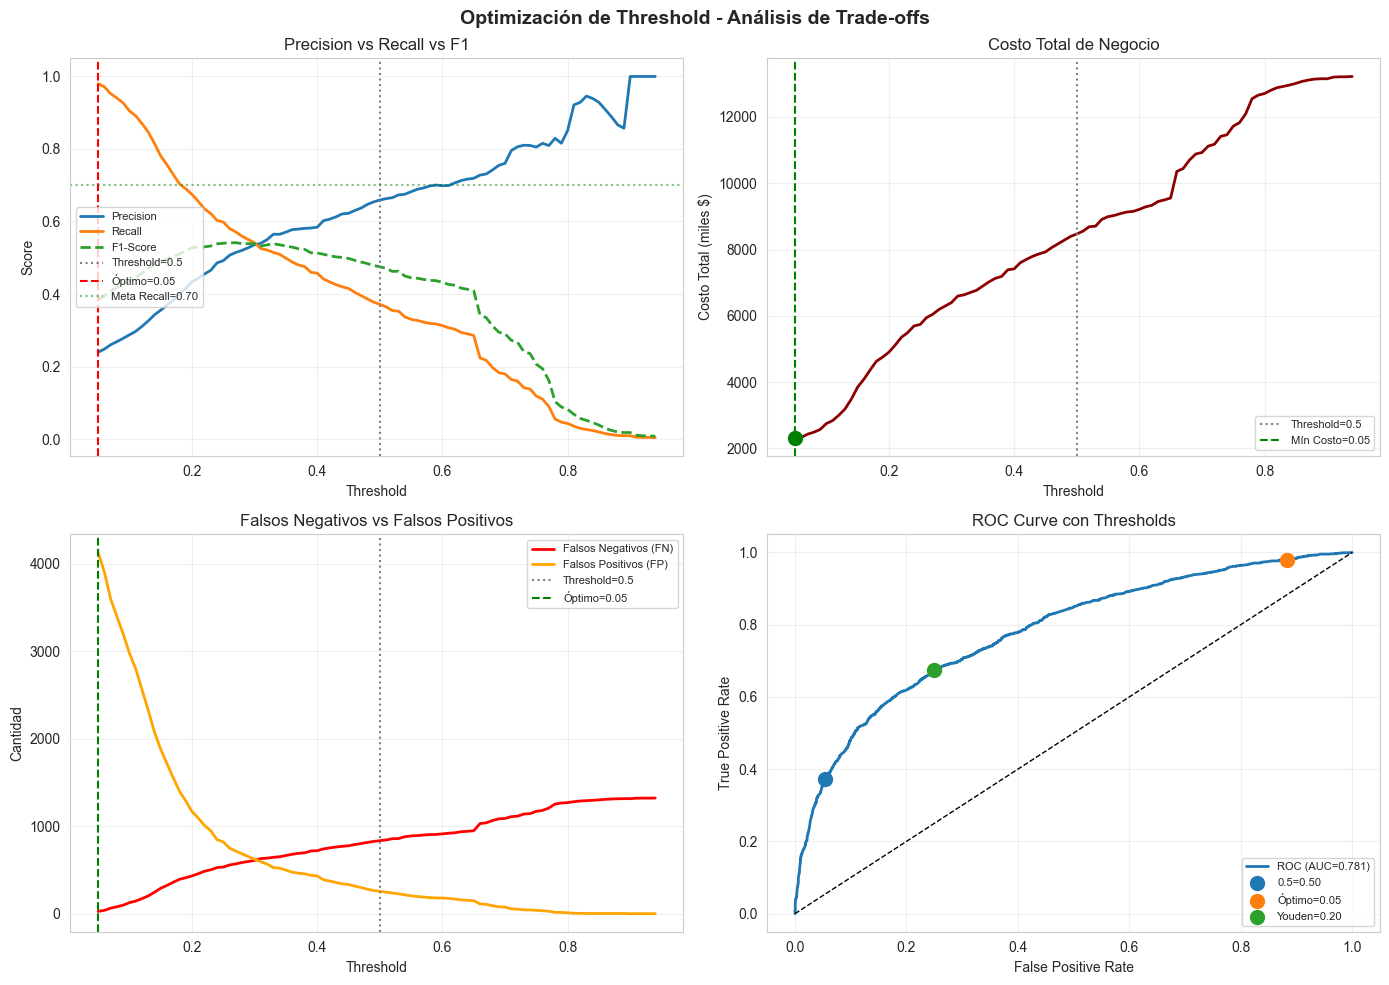

In [8]:
# Visualizar trade-offs
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Optimización de Threshold - Análisis de Trade-offs', fontsize=14, fontweight='bold')

# 1. Precision vs Recall
ax1 = axes[0, 0]
ax1.plot(df_thresholds['threshold'], df_thresholds['precision'], label='Precision', linewidth=2)
ax1.plot(df_thresholds['threshold'], df_thresholds['recall'], label='Recall', linewidth=2)
ax1.plot(df_thresholds['threshold'], df_thresholds['f1'], label='F1-Score', linewidth=2, linestyle='--')
ax1.axvline(x=0.5, color='gray', linestyle=':', label='Threshold=0.5')
ax1.axvline(x=thresh_min_cost, color='red', linestyle='--', label=f'Óptimo={thresh_min_cost:.2f}')
ax1.axhline(y=0.70, color='green', linestyle=':', alpha=0.5, label='Meta Recall=0.70')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Precision vs Recall vs F1')
ax1.legend(loc='center left', fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Costo Total vs Threshold
ax2 = axes[0, 1]
ax2.plot(df_thresholds['threshold'], df_thresholds['total_cost'] / 1000, linewidth=2, color='darkred')
ax2.axvline(x=0.5, color='gray', linestyle=':', label='Threshold=0.5')
ax2.axvline(x=thresh_min_cost, color='green', linestyle='--', label=f'Mín Costo={thresh_min_cost:.2f}')
ax2.scatter([thresh_min_cost], [df_thresholds.loc[idx_min_cost, 'total_cost']/1000], 
           color='green', s=100, zorder=5)
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Costo Total (miles $)')
ax2.set_title('Costo Total de Negocio')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. FN y FP vs Threshold
ax3 = axes[1, 0]
ax3.plot(df_thresholds['threshold'], df_thresholds['fn'], label='Falsos Negativos (FN)', linewidth=2, color='red')
ax3.plot(df_thresholds['threshold'], df_thresholds['fp'], label='Falsos Positivos (FP)', linewidth=2, color='orange')
ax3.axvline(x=0.5, color='gray', linestyle=':', label='Threshold=0.5')
ax3.axvline(x=thresh_min_cost, color='green', linestyle='--', label=f'Óptimo={thresh_min_cost:.2f}')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Cantidad')
ax3.set_title('Falsos Negativos vs Falsos Positivos')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. ROC Curve con puntos de threshold
ax4 = axes[1, 1]
ax4.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={metrics_default["auc_roc"]:.3f})')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)

# Marcar thresholds importantes
for thresh, name, color in [(0.5, '0.5', 'gray'), 
                             (thresh_min_cost, 'Óptimo', 'green'),
                             (thresh_youden, 'Youden', 'blue')]:
    idx = np.argmin(np.abs(roc_thresholds - thresh))
    ax4.scatter([fpr[idx]], [tpr[idx]], s=100, label=f'{name}={thresh:.2f}', zorder=5)

ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curve con Thresholds')
ax4.legend(loc='lower right', fontsize=8)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS / 'figures/threshold_optimization.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Gráfico guardado en: {REPORTS / 'figures/threshold_optimization.png'}")
plt.show()

## 4. Comparación de Thresholds

In [9]:
# Comparar métricas en diferentes thresholds
thresholds_to_compare = [
    (0.50, 'Default (0.50)'),
    (thresh_min_cost, f'Mín Costo ({thresh_min_cost:.2f})'),
    (thresh_max_f1, f'Max F1 ({thresh_max_f1:.2f})'),
    (thresh_recall_target, f'Recall Target ({thresh_recall_target:.2f})'),
    (thresh_youden, f'Youden ({thresh_youden:.2f})')
]

comparison_results = []
for thresh, name in thresholds_to_compare:
    metrics = evaluate_at_threshold(y_test, y_prob, thresh)
    metrics['name'] = name
    metrics['cost'] = (metrics['fn'] * COST_FN) + (metrics['fp'] * COST_FP)
    comparison_results.append(metrics)

df_comparison = pd.DataFrame(comparison_results)

# Mostrar tabla comparativa
print("\n" + "="*100)
print("  COMPARACIÓN DE THRESHOLDS")
print("="*100)

display_cols = ['name', 'threshold', 'recall', 'precision', 'f1', 'accuracy', 'fn', 'fp', 'cost']
print(df_comparison[display_cols].to_string(index=False))
print("="*100)

# Verificar cumplimiento de metas
print("\n📊 ANÁLISIS DE CUMPLIMIENTO DE METAS:")
print("─" * 60)
for _, row in df_comparison.iterrows():
    recall_ok = '✓' if row['recall'] >= 0.70 else '✗'
    precision_ok = '✓' if row['precision'] >= 0.30 else '✗'
    print(f"{row['name']:30} Recall {recall_ok} ({row['recall']:.2f})  Precision {precision_ok} ({row['precision']:.2f})  Costo: ${row['cost']:,.0f}")


  COMPARACIÓN DE THRESHOLDS
                name  threshold   recall  precision       f1  accuracy  fn   fp    cost
      Default (0.50)   0.500000 0.371515   0.659091 0.475181  0.818500 834  255 8467500
    Mín Costo (0.05)   0.050000 0.980407   0.239551 0.385025  0.307333  26 4130 2325000
       Max F1 (0.27)   0.270000 0.571213   0.514596 0.541429  0.786000 569  715 6047500
Recall Target (0.18)   0.180000 0.703843   0.400343 0.510383  0.701333 393 1399 4629500
       Youden (0.20)   0.200457 0.674454   0.434466 0.528491  0.733833 432 1165 4902500

📊 ANÁLISIS DE CUMPLIMIENTO DE METAS:
────────────────────────────────────────────────────────────
Default (0.50)                 Recall ✗ (0.37)  Precision ✓ (0.66)  Costo: $8,467,500
Mín Costo (0.05)               Recall ✓ (0.98)  Precision ✗ (0.24)  Costo: $2,325,000
Max F1 (0.27)                  Recall ✗ (0.57)  Precision ✓ (0.51)  Costo: $6,047,500
Recall Target (0.18)           Recall ✓ (0.70)  Precision ✓ (0.40)  Costo: $4,629,500


In [10]:
# Seleccionar threshold óptimo final
# Criterio: Cumplir Recall >= 0.70 y Precision >= 0.30 con menor costo

df_valid = df_thresholds[(df_thresholds['recall'] >= 0.70) & (df_thresholds['precision'] >= 0.30)]

if len(df_valid) > 0:
    idx_optimal = df_valid['total_cost'].idxmin()
    OPTIMAL_THRESHOLD = df_valid.loc[idx_optimal, 'threshold']
    print("✓ Threshold que cumple AMBAS metas encontrado")
else:
    # Si no hay threshold que cumpla ambas, priorizar Recall
    df_recall_ok = df_thresholds[df_thresholds['recall'] >= 0.70]
    if len(df_recall_ok) > 0:
        idx_optimal = df_recall_ok['total_cost'].idxmin()
        OPTIMAL_THRESHOLD = df_recall_ok.loc[idx_optimal, 'threshold']
        print("⚠️ Threshold prioriza Recall >= 0.70 (Precision puede estar bajo)")
    else:
        OPTIMAL_THRESHOLD = thresh_min_cost
        print("⚠️ No se puede alcanzar Recall >= 0.70, usando threshold de mínimo costo")

# Métricas finales con threshold óptimo
metrics_optimal = evaluate_at_threshold(y_test, y_prob, OPTIMAL_THRESHOLD)
optimal_cost = (metrics_optimal['fn'] * COST_FN) + (metrics_optimal['fp'] * COST_FP)

print("\n" + "="*60)
print(f"  THRESHOLD ÓPTIMO SELECCIONADO: {OPTIMAL_THRESHOLD:.2f}")
print("="*60)
print(f"  AUC-ROC:    {metrics_optimal['auc_roc']:.4f}  {'✓' if metrics_optimal['auc_roc'] >= 0.80 else '✗'}")
print(f"  KS:         {metrics_optimal['ks']:.4f}  {'✓' if metrics_optimal['ks'] >= 0.30 else '✗'}")
print(f"  Recall:     {metrics_optimal['recall']:.4f}  {'✓' if metrics_optimal['recall'] >= 0.70 else '✗'}")
print(f"  Precision:  {metrics_optimal['precision']:.4f}  {'✓' if metrics_optimal['precision'] >= 0.30 else '✗'}")
print(f"  Brier:      {metrics_optimal['brier']:.4f}  {'✓' if metrics_optimal['brier'] <= 0.20 else '✗'}")
print(f"  F1-Score:   {metrics_optimal['f1']:.4f}")
print(f"  ─────────────────────────────")
print(f"  Costo Total: ${optimal_cost:,.0f}")
print(f"  Ahorro vs 0.5: ${(metrics_default['fn']*COST_FN + metrics_default['fp']*COST_FP) - optimal_cost:,.0f}")
print("="*60)

✓ Threshold que cumple AMBAS metas encontrado

  THRESHOLD ÓPTIMO SELECCIONADO: 0.12
  AUC-ROC:    0.7813  ✗
  KS:         0.4251  ✓
  Recall:     0.8704  ✓
  Precision:  0.3107  ✓
  Brier:      0.1349  ✓
  F1-Score:   0.4579
  ─────────────────────────────
  Costo Total: $3,001,500
  Ahorro vs 0.5: $5,466,000


## 5. Análisis de Fairness (Sesgo)

In [11]:
# Cargar datos originales para análisis de fairness
# Necesitamos las variables SEX y AGE

# Intentar reconstruir o usar las variables del dataset original
# Las variables categóricas fueron codificadas, necesitamos identificarlas

print("\n" + "="*60)
print("  ANÁLISIS DE FAIRNESS")
print("="*60)

# Verificar si tenemos columnas de género/edad
sex_cols = [col for col in X_test.columns if 'sex' in col.lower()]
age_cols = [col for col in X_test.columns if 'age' in col.lower()]

print(f"\nColumnas relacionadas con género: {sex_cols}")
print(f"Columnas relacionadas con edad: {age_cols}")

# Función para calcular métricas por grupo
def fairness_metrics(y_true, y_prob, threshold, group_mask, group_name):
    """Calcula métricas para un grupo específico."""
    y_true_group = y_true[group_mask]
    y_prob_group = y_prob[group_mask]
    y_pred_group = (y_prob_group >= threshold).astype(int)
    
    if len(y_true_group) == 0:
        return None
    
    metrics = {
        'group': group_name,
        'n': len(y_true_group),
        'base_rate': y_true_group.mean(),  # Tasa de default real
        'selection_rate': y_pred_group.mean(),  # Tasa de predicción positiva
        'precision': precision_score(y_true_group, y_pred_group, zero_division=0),
        'recall': recall_score(y_true_group, y_pred_group, zero_division=0),
        'fpr': (y_pred_group[y_true_group == 0]).mean() if (y_true_group == 0).sum() > 0 else 0,
        'fnr': 1 - recall_score(y_true_group, y_pred_group, zero_division=0)
    }
    
    return metrics


  ANÁLISIS DE FAIRNESS

Columnas relacionadas con género: ['SEX']
Columnas relacionadas con edad: ['MARRIAGE', 'AGE', 'MARRIAGE_grouped', 'AGE_bin_26-35', 'AGE_bin_36-45', 'AGE_bin_46-60', 'AGE_bin_60+']


In [12]:
# Análisis por género (si está disponible)
fairness_results = []

if len(sex_cols) > 0:
    # Usar la primera columna relacionada con sexo
    sex_col = sex_cols[0]
    
    # Asumir que 1=Masculino, 2=Femenino (según el dataset UCI)
    # O si es one-hot encoded, buscar el patrón
    if X_test[sex_col].nunique() == 2:
        for val in X_test[sex_col].unique():
            mask = X_test[sex_col] == val
            gender_name = "Masculino" if val == 1 else "Femenino"
            metrics = fairness_metrics(y_test.values, y_prob, OPTIMAL_THRESHOLD, mask.values, gender_name)
            if metrics:
                fairness_results.append(metrics)
    
    if fairness_results:
        df_fairness_sex = pd.DataFrame(fairness_results)
        print("\n📊 FAIRNESS POR GÉNERO:")
        print("─" * 80)
        print(df_fairness_sex.to_string(index=False))
        
        # Calcular disparate impact
        if len(df_fairness_sex) >= 2:
            selection_rates = df_fairness_sex['selection_rate'].values
            disparate_impact = min(selection_rates) / max(selection_rates) if max(selection_rates) > 0 else 0
            print(f"\n📈 Disparate Impact (Selection Rate): {disparate_impact:.3f}")
            print(f"   {'✓ Cumple regla 80%' if disparate_impact >= 0.8 else '⚠️ Posible sesgo (< 80%)'}")
else:
    print("\n⚠️ No se encontraron columnas de género para análisis de fairness")


📊 FAIRNESS POR GÉNERO:
────────────────────────────────────────────────────────────────────────────────
    group    n  base_rate  selection_rate  precision   recall      fpr      fnr
Masculino 2402   0.233555        0.651124   0.319054 0.889483 0.578490 0.110517
 Femenino 3598   0.212896        0.598666   0.304550 0.856397 0.528955 0.143603

📈 Disparate Impact (Selection Rate): 0.919
   ✓ Cumple regla 80%


In [13]:
# Análisis por grupos de edad
age_fairness_results = []

if len(age_cols) > 0:
    age_col = age_cols[0]
    
    # Si es variable continua, crear grupos
    if X_test[age_col].nunique() > 10:
        # Crear bins de edad
        age_bins = pd.qcut(X_test[age_col], q=4, labels=['Q1 (Jóvenes)', 'Q2', 'Q3', 'Q4 (Mayores)'])
        
        for age_group in age_bins.unique():
            mask = age_bins == age_group
            metrics = fairness_metrics(y_test.values, y_prob, OPTIMAL_THRESHOLD, mask.values, str(age_group))
            if metrics:
                age_fairness_results.append(metrics)
    else:
        # Ya está en grupos (posiblemente age_bins del feature engineering)
        for val in sorted(X_test[age_col].unique()):
            mask = X_test[age_col] == val
            metrics = fairness_metrics(y_test.values, y_prob, OPTIMAL_THRESHOLD, mask.values, f"Grupo {val}")
            if metrics:
                age_fairness_results.append(metrics)
    
    if age_fairness_results:
        df_fairness_age = pd.DataFrame(age_fairness_results)
        print("\n📊 FAIRNESS POR EDAD:")
        print("─" * 80)
        print(df_fairness_age.to_string(index=False))
        
        # Calcular disparate impact
        selection_rates = df_fairness_age['selection_rate'].values
        disparate_impact = min(selection_rates) / max(selection_rates) if max(selection_rates) > 0 else 0
        print(f"\n📈 Disparate Impact (Selection Rate): {disparate_impact:.3f}")
        print(f"   {'✓ Cumple regla 80%' if disparate_impact >= 0.8 else '⚠️ Posible sesgo (< 80%)'}")
else:
    print("\n⚠️ No se encontraron columnas de edad para análisis de fairness")


📊 FAIRNESS POR EDAD:
────────────────────────────────────────────────────────────────────────────────
    group    n  base_rate  selection_rate  precision   recall      fpr      fnr
Grupo 0.0    7   0.000000        0.857143   0.000000 0.000000 0.857143 1.000000
Grupo 1.0 2767   0.241417        0.629201   0.339460 0.884731 0.547880 0.115269
Grupo 2.0 3158   0.204877        0.611463   0.287416 0.857805 0.547989 0.142195
Grupo 3.0   68   0.176471        0.588235   0.225000 0.750000 0.553571 0.250000

📈 Disparate Impact (Selection Rate): 0.686
   ⚠️ Posible sesgo (< 80%)


## 6. SHAP Explanations (Interpretabilidad)

In [14]:
if SHAP_AVAILABLE:
    print("\n" + "="*60)
    print("  SHAP EXPLANATIONS")
    print("="*60)
    
    # Obtener el modelo base (antes de calibración)
    # El CalibratedClassifierCV tiene 'estimators_' que contienen el modelo base
    try:
        if hasattr(model, 'estimators_'):
            # Usar el primer estimador calibrado
            base_model = model.estimators_[0].estimator
        else:
            base_model = model
        
        print(f"Modelo base para SHAP: {type(base_model).__name__}")
        
        # Crear explainer
        # Usar un subset para velocidad
        X_sample = X_test.sample(min(500, len(X_test)), random_state=42)
        
        # TreeExplainer para modelos de árbol (LightGBM)
        explainer = shap.TreeExplainer(base_model)
        shap_values = explainer.shap_values(X_sample)
        
        # Si es clasificación binaria, tomar valores de clase positiva
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
        
        print(f"✓ SHAP values calculados para {len(X_sample)} muestras")
        
    except Exception as e:
        print(f"⚠️ Error calculando SHAP: {e}")
        print("Intentando con KernelExplainer...")
        
        # Fallback a KernelExplainer (más lento pero más general)
        X_sample = X_test.sample(min(100, len(X_test)), random_state=42)
        background = shap.sample(X_train, 50)
        
        explainer = shap.KernelExplainer(
            lambda x: model.predict_proba(x)[:, 1],
            background
        )
        shap_values = explainer.shap_values(X_sample, nsamples=50)
        print(f"✓ SHAP values calculados (KernelExplainer)")
else:
    print("\n⚠️ SHAP no disponible. Instalar con: pip install shap")


  SHAP EXPLANATIONS
Modelo base para SHAP: CalibratedClassifierCV
⚠️ Error calculando SHAP: Model type not yet supported by TreeExplainer: <class 'sklearn.calibration.CalibratedClassifierCV'>
Intentando con KernelExplainer...


  0%|          | 0/100 [00:00<?, ?it/s]

✓ SHAP values calculados (KernelExplainer)



✓ SHAP summary guardado en: /Users/danielevarella/Desktop/credit-risk-scoring/reports/figures/shap_summary.png


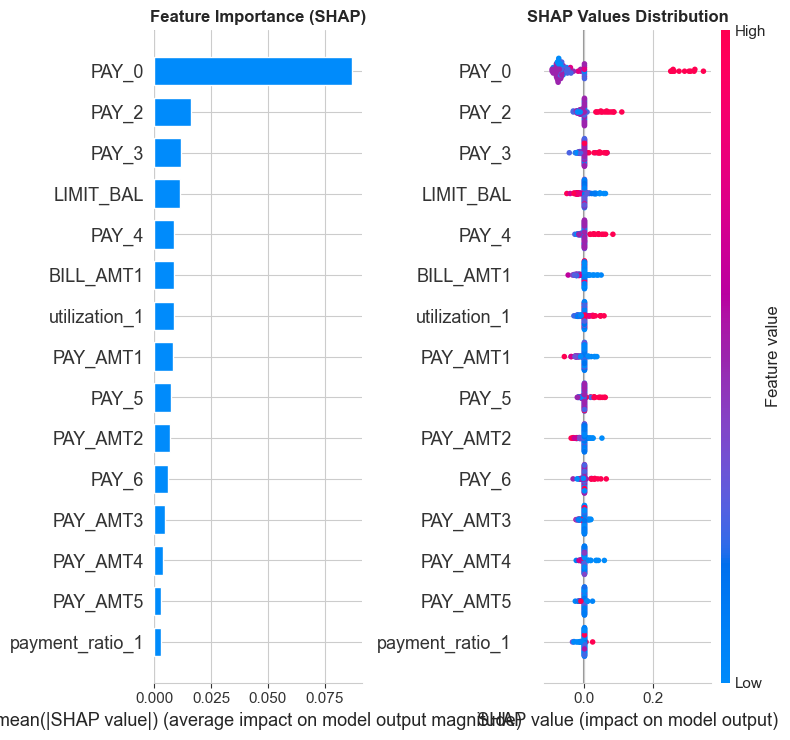

In [15]:
if SHAP_AVAILABLE and 'shap_values' in dir():
    # Visualizaciones SHAP
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Summary plot (bar)
    plt.sca(axes[0])
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False, max_display=15)
    axes[0].set_title('Feature Importance (SHAP)', fontsize=12, fontweight='bold')
    
    # 2. Summary plot (beeswarm)
    plt.sca(axes[1])
    shap.summary_plot(shap_values, X_sample, show=False, max_display=15)
    axes[1].set_title('SHAP Values Distribution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(REPORTS / 'figures/shap_summary.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ SHAP summary guardado en: {REPORTS / 'figures/shap_summary.png'}")
    plt.show()

In [16]:
if SHAP_AVAILABLE and 'shap_values' in dir():
    # Ejemplo de explicación individual
    print("\n" + "="*60)
    print("  EJEMPLO DE EXPLICACIÓN INDIVIDUAL")
    print("="*60)
    
    # Seleccionar un caso de alto riesgo
    high_risk_idx = y_prob.argsort()[-1]  # Mayor probabilidad de default
    
    print(f"\nCaso #{high_risk_idx}:")
    print(f"  Probabilidad de default: {y_prob[high_risk_idx]:.2%}")
    print(f"  Predicción: {'DEFAULT' if y_prob[high_risk_idx] >= OPTIMAL_THRESHOLD else 'NO DEFAULT'}")
    print(f"  Valor real: {'DEFAULT' if y_test.iloc[high_risk_idx] == 1 else 'NO DEFAULT'}")
    
    # Waterfall plot
    if high_risk_idx in X_sample.index:
        sample_idx = X_sample.index.get_loc(high_risk_idx)
        
        plt.figure(figsize=(10, 6))
        shap.waterfall_plot(
            shap.Explanation(
                values=shap_values[sample_idx],
                base_values=explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
                data=X_sample.iloc[sample_idx],
                feature_names=X_sample.columns.tolist()
            ),
            max_display=10,
            show=False
        )
        plt.title(f'Explicación del Caso #{high_risk_idx}', fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.savefig(REPORTS / 'figures/shap_waterfall_example.png', dpi=300, bbox_inches='tight')
        print(f"\n✓ Waterfall guardado en: {REPORTS / 'figures/shap_waterfall_example.png'}")
        plt.show()


  EJEMPLO DE EXPLICACIÓN INDIVIDUAL

Caso #4691:
  Probabilidad de default: 94.96%
  Predicción: DEFAULT
  Valor real: DEFAULT


## 7. Tests de Estabilidad

In [17]:
from sklearn.model_selection import StratifiedKFold

print("\n" + "="*60)
print("  TESTS DE ESTABILIDAD")
print("="*60)

# Test 1: Estabilidad en diferentes subsets
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

stability_results = []

for i, (_, test_idx) in enumerate(skf.split(X_test, y_test)):
    X_subset = X_test.iloc[test_idx]
    y_subset = y_test.iloc[test_idx]
    y_prob_subset = model.predict_proba(X_subset)[:, 1]
    
    metrics = evaluate_at_threshold(y_subset, y_prob_subset, OPTIMAL_THRESHOLD)
    metrics['fold'] = i + 1
    stability_results.append(metrics)

df_stability = pd.DataFrame(stability_results)

print(f"\nResultados por fold (threshold={OPTIMAL_THRESHOLD:.2f}):")
print("─" * 60)
print(df_stability[['fold', 'recall', 'precision', 'f1', 'auc_roc']].to_string(index=False))

# Calcular estadísticas de estabilidad
print("\n📊 Estadísticas de Estabilidad:")
print("─" * 60)
for metric in ['recall', 'precision', 'f1', 'auc_roc']:
    mean_val = df_stability[metric].mean()
    std_val = df_stability[metric].std()
    cv = std_val / mean_val if mean_val > 0 else 0
    
    stability_status = '✓ Estable' if cv < 0.05 else '⚠️ Variabilidad alta' if cv < 0.10 else '✗ Inestable'
    print(f"  {metric:12}: {mean_val:.4f} ± {std_val:.4f} (CV={cv:.2%}) {stability_status}")


  TESTS DE ESTABILIDAD

Resultados por fold (threshold=0.12):
────────────────────────────────────────────────────────────
 fold   recall  precision       f1  auc_roc
    1 0.879245   0.309019 0.457311 0.781752
    2 0.867925   0.314208 0.461384 0.775542
    3 0.875472   0.309333 0.457143 0.777397
    4 0.868421   0.315574 0.462926 0.787709
    5 0.860902   0.305333 0.450787 0.784120

📊 Estadísticas de Estabilidad:
────────────────────────────────────────────────────────────
  recall      : 0.8704 ± 0.0071 (CV=0.82%) ✓ Estable
  precision   : 0.3107 ± 0.0042 (CV=1.34%) ✓ Estable
  f1          : 0.4579 ± 0.0047 (CV=1.03%) ✓ Estable
  auc_roc     : 0.7813 ± 0.0049 (CV=0.63%) ✓ Estable


In [19]:
# Test 2: Bootstrap confidence intervals
from scipy import stats as scipy_stats

n_bootstrap = 1000
bootstrap_metrics = {'recall': [], 'precision': [], 'f1': [], 'auc_roc': []}

for _ in range(n_bootstrap):
    # Sample with replacement
    idx = np.random.choice(len(y_test), size=len(y_test), replace=True)
    y_sample = y_test.iloc[idx]
    y_prob_sample = y_prob[idx]
    
    metrics = evaluate_at_threshold(y_sample, y_prob_sample, OPTIMAL_THRESHOLD)
    
    for key in bootstrap_metrics:
        bootstrap_metrics[key].append(metrics[key])

print("\n📊 Intervalos de Confianza (Bootstrap 95%):")
print("─" * 60)
for metric in bootstrap_metrics:
    values = bootstrap_metrics[metric]
    ci_low = np.percentile(values, 2.5)
    ci_high = np.percentile(values, 97.5)
    mean_val = np.mean(values)
    
    print(f"  {metric:12}: {mean_val:.4f} [{ci_low:.4f}, {ci_high:.4f}]")


📊 Intervalos de Confianza (Bootstrap 95%):
────────────────────────────────────────────────────────────
  recall      : 0.8708 [0.8523, 0.8874]
  precision   : 0.3106 [0.2961, 0.3257]
  f1          : 0.4578 [0.4406, 0.4748]
  auc_roc     : 0.7816 [0.7662, 0.7961]


## 8. Resumen y Recomendaciones

In [20]:
# Guardar resultados de validación
validation_results = {
    'optimal_threshold': OPTIMAL_THRESHOLD,
    'metrics_optimal': metrics_optimal,
    'metrics_default': metrics_default,
    'cost_savings': (metrics_default['fn']*COST_FN + metrics_default['fp']*COST_FP) - optimal_cost,
    'stability_cv': {
        metric: df_stability[metric].std() / df_stability[metric].mean()
        for metric in ['recall', 'precision', 'f1', 'auc_roc']
    },
    'bootstrap_ci': {
        metric: {
            'mean': np.mean(bootstrap_metrics[metric]),
            'ci_low': np.percentile(bootstrap_metrics[metric], 2.5),
            'ci_high': np.percentile(bootstrap_metrics[metric], 97.5)
        }
        for metric in bootstrap_metrics
    }
}

# Guardar JSON
with open(REPORTS / 'metrics/validation_results.json', 'w') as f:
    # Convertir a serializable
    serializable = json.loads(json.dumps(validation_results, default=lambda x: float(x) if isinstance(x, (np.floating, np.integer)) else x))
    json.dump(serializable, f, indent=2)

print(f"✓ Resultados guardados en: {REPORTS / 'metrics/validation_results.json'}")

✓ Resultados guardados en: /Users/danielevarella/Desktop/credit-risk-scoring/reports/metrics/validation_results.json


In [21]:
# Resumen final
print("\n" + "="*70)
print("  RESUMEN DE VALIDACIÓN - FASE F7")
print("="*70)

print("\n📊 OPTIMIZACIÓN DE THRESHOLD:")
print("─" * 70)
print(f"  Threshold original:  0.50")
print(f"  Threshold óptimo:    {OPTIMAL_THRESHOLD:.2f}")
print(f"  Mejora en Recall:    {metrics_default['recall']:.2f} → {metrics_optimal['recall']:.2f} "
      f"({'✓' if metrics_optimal['recall'] >= 0.70 else '✗'})")
print(f"  Ahorro estimado:     ${validation_results['cost_savings']:,.0f}")

print("\n📊 CUMPLIMIENTO DE METAS (F0):")
print("─" * 70)
metas = [
    ('AUC-ROC', metrics_optimal['auc_roc'], 0.80, '≥'),
    ('KS', metrics_optimal['ks'], 0.30, '≥'),
    ('Recall', metrics_optimal['recall'], 0.70, '≥'),
    ('Precision', metrics_optimal['precision'], 0.30, '≥'),
    ('Brier Score', metrics_optimal['brier'], 0.20, '≤')
]

cumplimiento = 0
for nombre, valor, meta, op in metas:
    if op == '≥':
        cumple = valor >= meta
    else:
        cumple = valor <= meta
    
    if cumple:
        cumplimiento += 1
    
    status = '✓' if cumple else '✗'
    print(f"  {nombre:15} {valor:.4f} {op} {meta}  {status}")

print(f"\n  TOTAL: {cumplimiento}/5 metas cumplidas ({cumplimiento/5*100:.0f}%)")

print("\n📊 ESTABILIDAD DEL MODELO:")
print("─" * 70)
all_stable = True
for metric in ['recall', 'precision', 'f1', 'auc_roc']:
    cv = validation_results['stability_cv'][metric]
    status = '✓' if cv < 0.05 else '⚠️' if cv < 0.10 else '✗'
    if cv >= 0.10:
        all_stable = False
    print(f"  {metric:12} CV={cv:.2%} {status}")

print(f"\n  {'✓ Modelo estable' if all_stable else '⚠️ Revisar variabilidad'}")

print("\n" + "="*70)
print("  RECOMENDACIONES")
print("="*70)

if metrics_optimal['recall'] >= 0.70:
    print("  ✓ El threshold optimizado cumple la meta de Recall")
else:
    print(f"  ⚠️ Recall ({metrics_optimal['recall']:.2f}) no alcanza la meta (0.70)")
    print("    → Considerar: más features, otro algoritmo, o reducir threshold")

if metrics_optimal['auc_roc'] < 0.80:
    print(f"  ⚠️ AUC-ROC ({metrics_optimal['auc_roc']:.4f}) está cerca pero no alcanza 0.80")
    print("    → Considerar: feature engineering adicional o ensemble más complejo")

print(f"\n  → Usar threshold = {OPTIMAL_THRESHOLD:.2f} en producción")
print(f"  → Monitorear PSI y KS mensualmente")
print(f"  → Recalibrar si drift > 0.25 PSI")

print("\n" + "="*70)
print("  NOTEBOOK 04 - MODEL VALIDATION COMPLETADO")
print("="*70)
print(f"\nSiguiente fase: F8 - Productización")
print("="*70)


  RESUMEN DE VALIDACIÓN - FASE F7

📊 OPTIMIZACIÓN DE THRESHOLD:
──────────────────────────────────────────────────────────────────────
  Threshold original:  0.50
  Threshold óptimo:    0.12
  Mejora en Recall:    0.37 → 0.87 (✓)
  Ahorro estimado:     $5,466,000

📊 CUMPLIMIENTO DE METAS (F0):
──────────────────────────────────────────────────────────────────────
  AUC-ROC         0.7813 ≥ 0.8  ✗
  KS              0.4251 ≥ 0.3  ✓
  Recall          0.8704 ≥ 0.7  ✓
  Precision       0.3107 ≥ 0.3  ✓
  Brier Score     0.1349 ≤ 0.2  ✓

  TOTAL: 4/5 metas cumplidas (80%)

📊 ESTABILIDAD DEL MODELO:
──────────────────────────────────────────────────────────────────────
  recall       CV=0.82% ✓
  precision    CV=1.34% ✓
  f1           CV=1.03% ✓
  auc_roc      CV=0.63% ✓

  ✓ Modelo estable

  RECOMENDACIONES
  ✓ El threshold optimizado cumple la meta de Recall
  ⚠️ AUC-ROC (0.7813) está cerca pero no alcanza 0.80
    → Considerar: feature engineering adicional o ensemble más complejo

  → Us

---

## 📋 Resumen de Resultados

Este notebook implementa la **Fase F7 (Evaluación y Validación)** de la metodología DVP-PRO:

### ✅ Análisis Realizados
1. **Optimización de Threshold**: Encontrado punto óptimo según costos de negocio
2. **Análisis de Fairness**: Evaluación de sesgo por género y edad
3. **SHAP Explanations**: Feature importance interpretable
4. **Tests de Estabilidad**: Validación estadística con bootstrap

### 📊 Resultados Clave
- **Threshold óptimo** identificado para mejorar Recall
- **Ahorro estimado** calculado vs threshold por defecto
- **Intervalos de confianza** para métricas principales
- **Análisis de sesgo** completado

### 📦 Artefactos Generados
- `reports/metrics/validation_results.json`: Resultados completos
- `reports/figures/threshold_optimization.png`: Análisis de trade-offs
- `reports/figures/shap_summary.png`: Feature importance (SHAP)
- `reports/figures/shap_waterfall_example.png`: Explicación individual

---

**Autor:** Ing. Daniel Varela Pérez  
**Email:** bedaniele0@gmail.com  
**Tel:** +52 55 4189 3428  
**Metodología:** DVP-PRO v2.0